## 1. Module Import

In [41]:
# self defined Modules
from myModules.plot.plotWordCloud import plotWordCloud
from myModules.TopicModeling.LDA.ldaModeling import buildDTM, topicWords, visualizeLDA

# General Modules
import pandas as pd
import numpy as np
import warnings
from tqdm.notebook import tqdm
import pickle
from itertools import product
import operator

warnings.filterwarnings('ignore')

# NLP
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

# Visualization
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
%matplotlib inline

## 2. Data Load

In [5]:
DATA_ROOT = './processed-data/chosun/'

RESULT_ROOT = './Result/chosun/'

In [6]:
with open(DATA_ROOT+"lemmatized-all.pkl", "rb") as f:
    all = pickle.load(f)
with open(DATA_ROOT+"lemmatized-noun.pkl", "rb") as f:
    noun = pickle.load(f)
with open(DATA_ROOT+"lemmatized-verb.pkl", "rb") as f:
    verb = pickle.load(f)
with open(DATA_ROOT+"lemmatized-adjective.pkl", "rb") as f:
    adjective = pickle.load(f)
with open(DATA_ROOT+"lemmatized-adverb.pkl", "rb") as f:
    adverb = pickle.load(f)

## 3. Analysis

### 3-1. Word Cloud

#### All pos

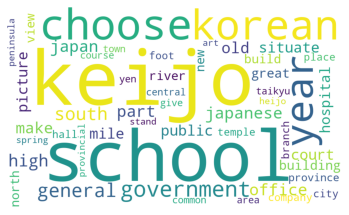

In [9]:
plotWordCloud(*all, filepath=RESULT_ROOT+'all-', mode='ST')

#### Noun

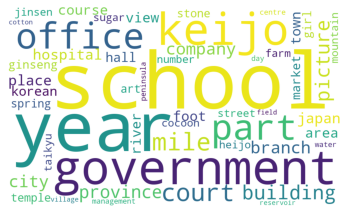

In [10]:
plotWordCloud(*noun, filepath=RESULT_ROOT+'noun-', mode='ST')

#### Verb

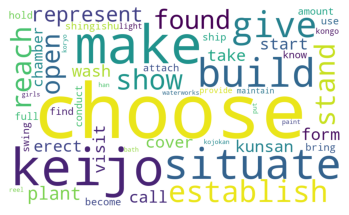

In [11]:
plotWordCloud(*verb, filepath=RESULT_ROOT+'verb-', mode='ST')

#### Adjective

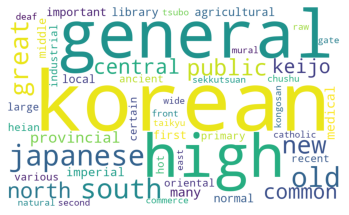

In [12]:
plotWordCloud(*adjective, filepath=RESULT_ROOT+'adjective-', mode='ST')

#### Adverb

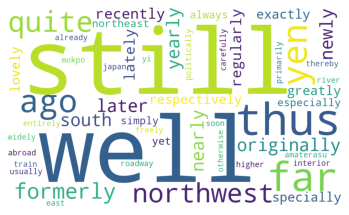

In [13]:
plotWordCloud(*adverb, filepath=RESULT_ROOT+'adverb-', mode='ST')

### 3-2. Topic Modeling

#### Parameter

In [14]:
NUM_TOPIC_WORDS = 30
random_state = 42

#### Define Parameter Optimizer

In [17]:
class BestLDAPram:
    def __init__(self, data, random_state=42):
        self.data = data
        self.random_state = random_state
        self.corpus, self.dictionary = buildDTM(self.data)
    
    def grid_search(self, param_grid, result_save_root='./'):
        grid_search_table = []

        iterator = list(product(param_grid['num_topics'], param_grid['alpha'], param_grid['eta']))

        for num_topic, alpha, eta in tqdm(iterator, desc="LDA Parameter Grid Searching"):
            coherence_value = self.calc_coherence(num_topic=num_topic, alpha=alpha, eta=eta)
            grid_search_table.append([num_topic, alpha, eta, coherence_value])
        
        self.grid_search_table = pd.DataFrame(grid_search_table)
        self.grid_search_table.columns = ['Topics', 'Alpha', 'Eta', 'Coherence']

        self.grid_search_table.to_csv(result_save_root+'lda-param-grid-search.csv', index=False)
    
    def calc_coherence(self, num_topic, alpha, eta):
        model = models.LdaMulticore(corpus=self.corpus, id2word=self.dictionary, num_topics=num_topic, \
            alpha=alpha, eta=eta, random_state=self.random_state)
        
        coherence_model = CoherenceModel(model=model, texts=self.data, dictionary=self.dictionary, coherence='c_v')
        
        return coherence_model.get_coherence()
    
    def load_grid_search_result(self, grid_search_result):
        self.grid_search_table = grid_search_result
    
    def get_best_params(self):
        num_topics = self.grid_search_table.Topics.unique()
        coherences = []
        for ntopic in num_topics:
            coherences.append(self.grid_search_table.Coherence[self.grid_search_table.Topics == ntopic].mean())
        
        idx = np.argmax(coherences)
        best_num_topics = num_topics[idx]

        alphas = self.grid_search_table.Alpha.unique()
        coherences = []
        for alpha in alphas:
            coherences.append(self.grid_search_table.Coherence[self.grid_search_table.Alpha == alpha].mean())
        
        idx = np.argmax(coherences)
        best_alpha = alphas[idx]
        
        etas = self.grid_search_table.Eta.unique()
        coherences = []
        for eta in etas:
            coherences.append(self.grid_search_table.Coherence[self.grid_search_table.Eta == eta].mean())
        
        idx = np.argmax(coherences)
        best_eta = etas[idx]

        return best_num_topics, best_alpha, best_eta
    
    def plot_coherence_per_topics(self, title='Coherence per Topic Num', root='./'):
        plt.figure()

        num_topics = self.grid_search_table.Topics.unique()
        coherences = []
        for ntopic in num_topics:
            coherences.append(self.grid_search_table.Coherence[self.grid_search_table.Topics == ntopic].mean())

        plt.plot(num_topics, coherences)

        plt.xlabel('Number of Topics')
        plt.ylabel('Coherence')

        plt.title(title)
        plt.savefig(root+title+'.png')
        plt.show()

    def plot_coherence_per_alpha(self, title='Coherence per alpha', root='./'):
        plt.figure()

        alphas = self.grid_search_table.Alpha.unique()
        coherences = []
        for alpha in alphas:
            coherences.append(self.grid_search_table.Coherence[self.grid_search_table.Alpha == alpha].mean())

        plt.plot(alphas, coherences)

        plt.xlabel('Alpha')
        plt.ylabel('Coherence')

        plt.title(title)
        plt.savefig(root+title+'.png')
        plt.show()
    
    def plot_coherence_per_eta(self, title='Coherence per eta', root='./'):
        plt.figure()

        etas = self.grid_search_table.Eta.unique()
        coherences = []
        for eta in etas:
            coherences.append(self.grid_search_table.Coherence[self.grid_search_table.Eta == eta].mean())

        plt.plot(etas, coherences)

        plt.xlabel('Eta')
        plt.ylabel('Coherence')

        plt.title(title)
        plt.savefig(root+title+'.png')
        plt.show()

#### Parameter Grid Search (opitize)

In [28]:
lda_param = BestLDAPram(data=all, random_state=random_state)

In [49]:
num_topics = range(1, 10)
alpha = list(np.arange(0.01, 1, 0.2))
eta = list(np.arange(0.01, 1, 0.2))

param_grid = {
    'num_topics' : num_topics,
    'alpha' : alpha,
    'eta' : eta
}

In [50]:
lda_param.grid_search(param_grid=param_grid)

LDA Parameter Grid Searching:   0%|          | 0/225 [00:00<?, ?it/s]

#### Get Best Parameter

In [51]:
NUM_TOPICS, ALPHA, ETA = lda_param.get_best_params()

print(f"best Number of Topics : {NUM_TOPICS}\nbest Alpha : {ALPHA}\nbest Eta : {ETA}")

best Number of Topics : 5
best Alpha : 0.01
best Eta : 0.81


#### Plot Coherence Graph about Topic Number

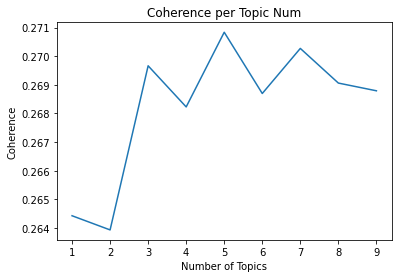

In [52]:
lda_param.plot_coherence_per_topics()

#### Plot Coherence Graph about Alpha

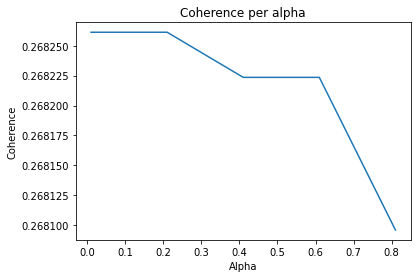

In [53]:
lda_param.plot_coherence_per_alpha()

#### Plot Coherence Graph about Eta

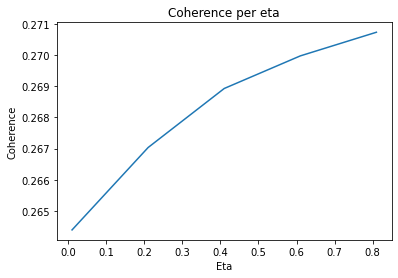

In [54]:
lda_param.plot_coherence_per_eta()

#### Topic Modeling With Best Parameter

In [55]:
Corp, Dict = buildDTM(all)
model = models.ldamodel.LdaModel(corpus=Corp, id2word=Dict, num_topics=NUM_TOPICS, \
            alpha=ALPHA, eta=ETA, random_state=random_state)
topicdf = topicWords(model, NUM_TOPIC_WORDS)
topicdf.to_csv(RESULT_ROOT+'topic words.csv', index=False)
data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.003013  0.002613       1        1  99.998533
0      0.000674 -0.000866       2        1   0.000367
1     -0.000277 -0.000532       3        1   0.000367
2      0.001846 -0.001172       4        1   0.000367
3      0.000769 -0.000043       5        1   0.000367, topic_info=            Term       Freq      Total Category  logprob  loglift
534        keijo  26.000000  26.000000  Default  30.0000  30.0000
882       school  21.000000  21.000000  Default  29.0000  29.0000
154       choose  18.000000  18.000000  Default  28.0000  28.0000
555       korean  16.000000  16.000000  Default  27.0000  27.0000
430   government  16.000000  16.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
947        south   0.000022  11.199237   Topic5  -6.1270  -0.6319
439        great   0.000019   7.877783   Topic5  -6.2528  -0.4059
789       public   0.000019   8.579361   Topic5  -6.2429  -0.4813
480     hospital   0.000019   8.423430   Topic5  -6.2523  -0.4724
1098        view   0.000018   6.821284   Topic5  -6.3072  -0.3163

[394 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
8         1  1.291229     addition
45        1  0.961504         area
47        1  1.247717  arrangement
63        1  1.266584   background
64        1  0.836142       bamboo
...     ...       ...          ...
1118      1  1.073610         well
1135      1  0.977058         yalu
1136      1  0.967954         year
1140      1  1.023968          yen
1145      1  1.315033   zoological

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 3, 4])

### 3-3. Network Web Analysis

#### Define Voca Calculator & Network Visualizer

In [42]:
class vocaDict:
    def __init__(self):
        self.word2id = {}
        self.id2word = []
        self.count = {}
    
    def getIdOrAdd(self, word):
        if word in self.word2id:
            return self.word2id[word]
        self.word2id[word] = len(self.word2id)
        self.id2word.append(word)
        return len(self.word2id) - 1
    
    def getWord(self, id):
        return self.id2word[id]
    
    def calcWordPairFreq(self, text):
        wordIds = [self.getIdOrAdd(word) for word in text]
        for idx, a in enumerate(tqdm(wordIds, desc="Word Pair Frequency ")):
            for b in wordIds[idx+1:]:
                if a == b: continue
                if a > b: a, b = b, a
                self.count[a, b] = self.count.get((a, b), 0) + 1
        return self.count
    
    def to_csv(self, file_name, root='./'):
        df = []
        for key, val in self.count.items():
            df.append([self.getWord(key[0]), self.getWord(key[1]), val])
        df = pd.DataFrame(df, columns=['word1', 'word2', 'freq'])
        df = df.sort_values(by=['freq'], ascending=False)
        df = df.reset_index(drop=True)

        df.to_csv(root+'word-pair-freq-'+file_name+'.csv', index=False)

class Network:
    def calc_properties(self, edge_num, data):
        self.edge_num = edge_num
        self.data = data
        self.max_freq = -1
        self.quartile = 0

        G_centrality = nx.Graph()

        for idx in range(self.edge_num):
            G_centrality.add_edge(self.data['word1'][idx], self.data['word2'][idx], weight=int(self.data['freq'][idx]))
            if self.max_freq < int(self.data['freq'][idx]): self.max_freq = int(self.data['freq'][idx])
        
        self.quartile = self.max_freq / 4
        
        self.dgr = nx.degree_centrality(G_centrality)
        self.pgr = nx.pagerank(G_centrality)

        self.dgr = sorted(self.dgr.items(), key=operator.itemgetter(1), reverse=True)
        self.pgr = sorted(self.pgr.items(), key=operator.itemgetter(1), reverse=True)
    
    def plot(self, title='Network Web Analysis', root='./'):
        G = nx.Graph()

        # node 추가
        for idx in range(len(self.pgr)):
            G.add_node(self.pgr[idx][0], weight=self.dgr[idx][1])
        
        # edge 추가
        for idx in range(self.edge_num):
            G.add_edge(self.data['word1'][idx], self.data['word2'][idx], weight=int(self.data['freq'][idx]))
        
        # 토폴로지 형태 정의
        # pos = graphviz_layout(G, prog='neato')
        pos = graphviz_layout(G, prog='twopi')

        # Network 시각화
        fig = plt.figure(figsize=(30, 20))
        plt.margins(x=0.1, y=0.2)
        ax = fig.gca()

        # figure에 node 그리기
        Blues_modified = cm.get_cmap('Blues', 256)
        newcmp = ListedColormap(Blues_modified(np.linspace(0.2, 0.8, 4)))
        nc = nx.draw_networkx_nodes(G, pos, node_size=[node[1]['weight']*20000 for node in G.nodes(data=True)], \
            node_color=[node[1]['weight'] for node in G.nodes(data=True)], cmap=newcmp,
            node_shape='o', alpha=0.9, linewidths=0.4, edgecolors='#000000')

        # figure에 label 그리기
        nx.draw_networkx_labels(G, pos=pos, font_size=16, alpha=0.7, font_color='black', font_weight='bold')

        # figure에 edge 그리기
        Greys_modified = cm.get_cmap('Greys', 256)
        newcmp = ListedColormap(Greys_modified(np.linspace(0.2, 1.0, 4)))
        ec = nx.draw_networkx_edges(G, pos, edge_color=[edge[2]['weight'] for edge in G.edges(data=True)], \
            edge_cmap=newcmp, style='solid', width=2, connectionstyle='arc3,rad=-0.3')
        
        # title 지정
        plt.title(title, fontsize=25)
        # axis 선 안보이게 설정
        plt.axis('off')

        # color bar 추가
        axins = inset_axes(ax,\
            width='1%',
            height='30%',
            loc='center right',
            borderpad=0)
        cbar = plt.colorbar(nc, cax=axins)
        cbar.ax.set_ylabel('Centrality', rotation=270, fontsize=12, labelpad=15)

        axins = inset_axes(ax, \
            width='1%',
            height='30%',
            loc='center left',
            borderpad=0)
        cbar = plt.colorbar(ec, cax=axins)
        cbar.ax.set_ylabel('Word Pair Freqency', rotation=270, fontsize=12, labelpad=15)

        # figure 저장
        plt.savefig(root+title+'.png')
        # figure 출력
        plt.show()

#### Calculate Word Pair Frequency

In [38]:
voca = vocaDict()
result = voca.calcWordPairFreq(*all)
voca.to_csv(file_name="all", root=RESULT_ROOT)

voca = vocaDict()
result = voca.calcWordPairFreq(*noun)
voca.to_csv(file_name="noun", root=RESULT_ROOT)

voca = vocaDict()
result = voca.calcWordPairFreq(*verb)
voca.to_csv(file_name="verb", root=RESULT_ROOT)

voca = vocaDict()
result = voca.calcWordPairFreq(*adjective)
voca.to_csv(file_name="adjective", root=RESULT_ROOT)

voca = vocaDict()
result = voca.calcWordPairFreq(*adverb)
voca.to_csv(file_name="adverb", root=RESULT_ROOT)

Word Pair Frequency :   0%|          | 0/2727 [00:00<?, ?it/s]

Word Pair Frequency :   0%|          | 0/1395 [00:00<?, ?it/s]

Word Pair Frequency :   0%|          | 0/500 [00:00<?, ?it/s]

Word Pair Frequency :   0%|          | 0/710 [00:00<?, ?it/s]

Word Pair Frequency :   0%|          | 0/122 [00:00<?, ?it/s]

In [39]:
all_freq = pd.read_csv(RESULT_ROOT+'word-pair-freq-all.csv')
noun_freq = pd.read_csv(RESULT_ROOT+'word-pair-freq-noun.csv')
verb_freq = pd.read_csv(RESULT_ROOT+'word-pair-freq-verb.csv')
adjective_freq = pd.read_csv(RESULT_ROOT+'word-pair-freq-adjective.csv')
adverb_freq = pd.read_csv(RESULT_ROOT+'word-pair-freq-adverb.csv')

#### All Pos

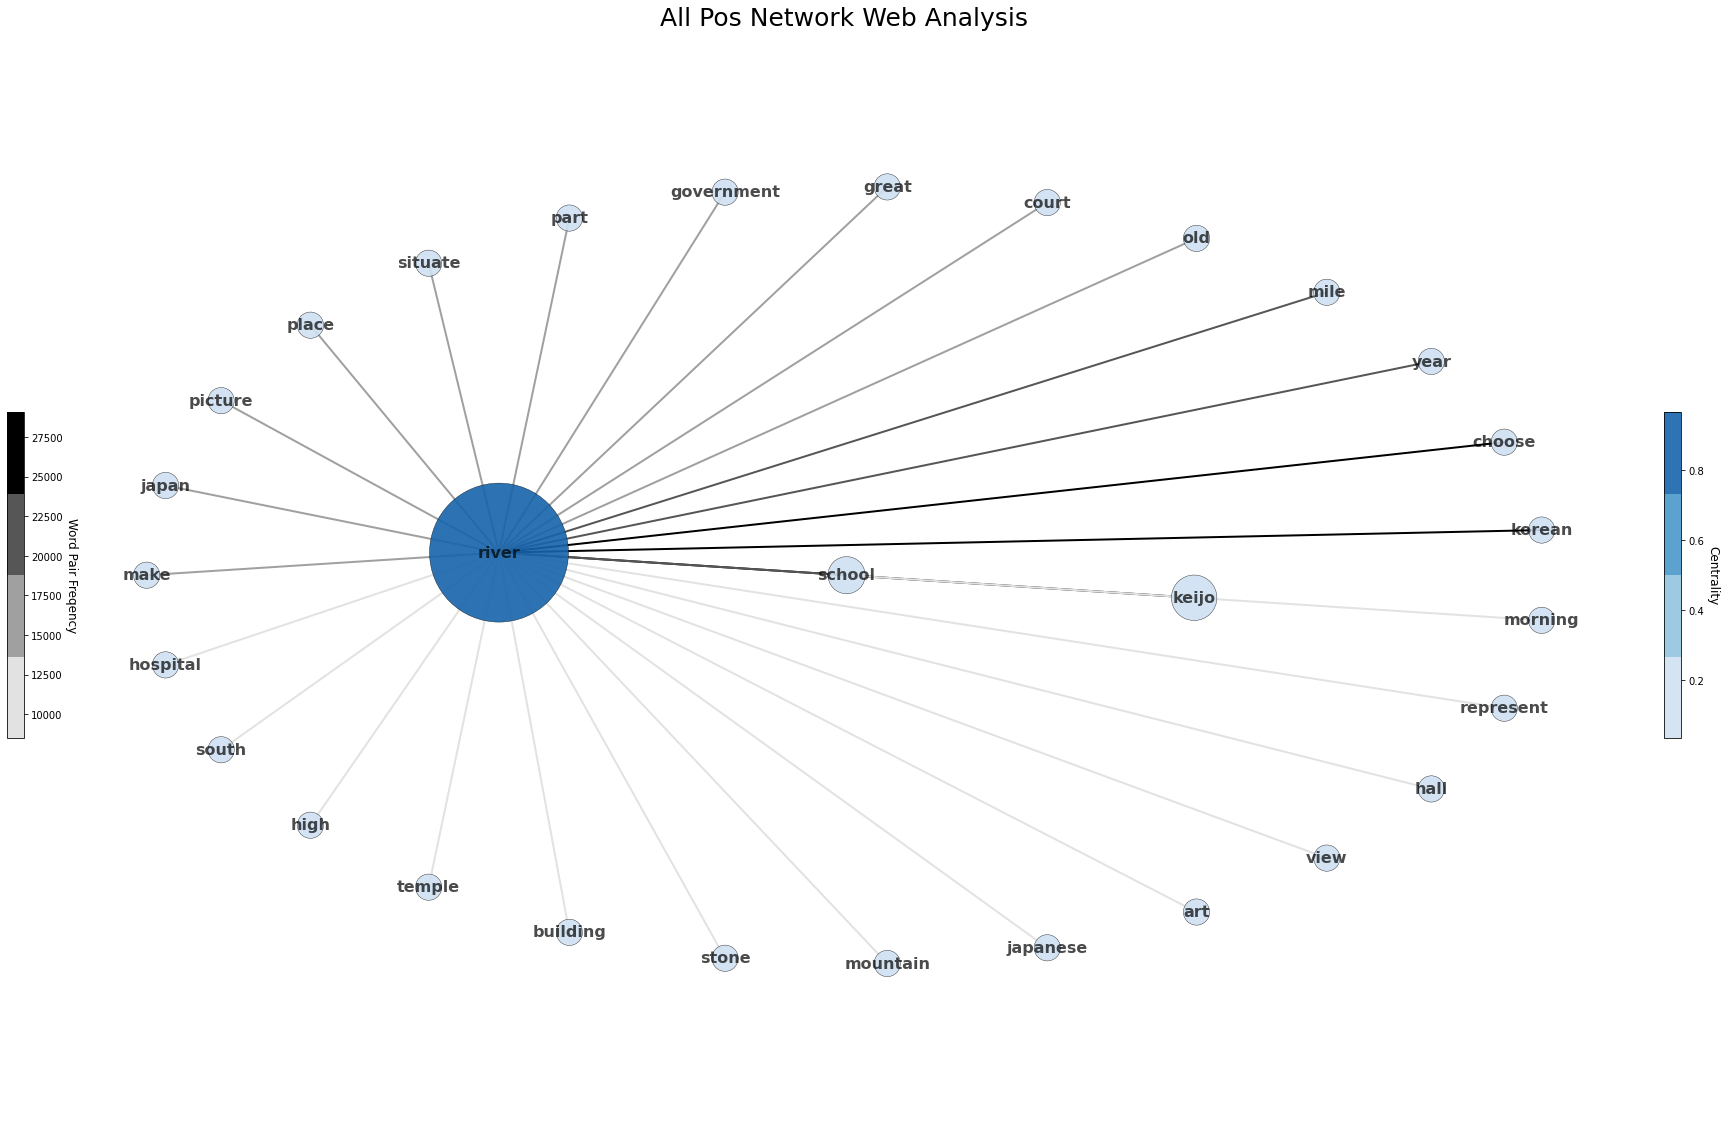

In [44]:
net = Network()

# '단어 중심성' 계산
# degree Centrality, Page Rank
net.calc_properties(edge_num=30, data=all_freq)

# Network 시각화
net.plot(title='All Pos Network Web Analysis', root=RESULT_ROOT)

#### Noun

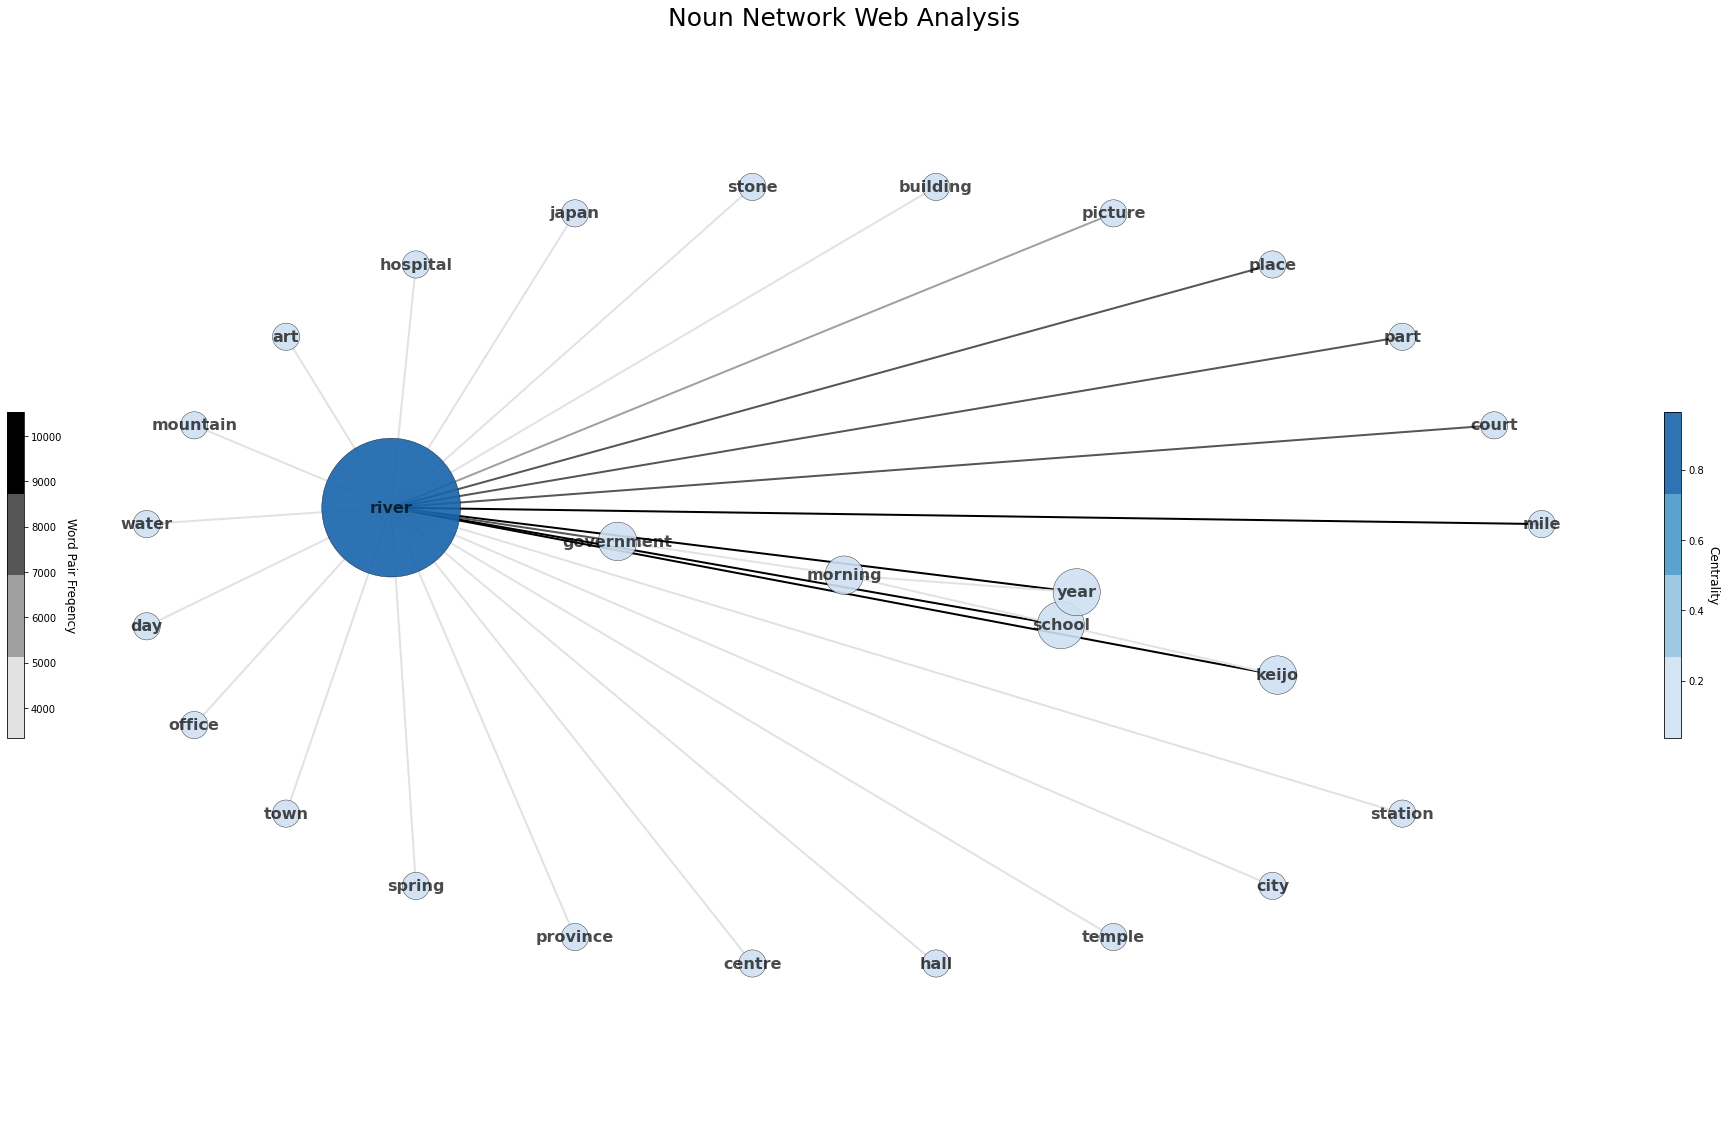

In [45]:
net = Network()

# '단어 중심성' 계산
# degree Centrality, Page Rank
net.calc_properties(edge_num=30, data=noun_freq)

# Network 시각화
net.plot(title='Noun Network Web Analysis', root=RESULT_ROOT)

#### Verb

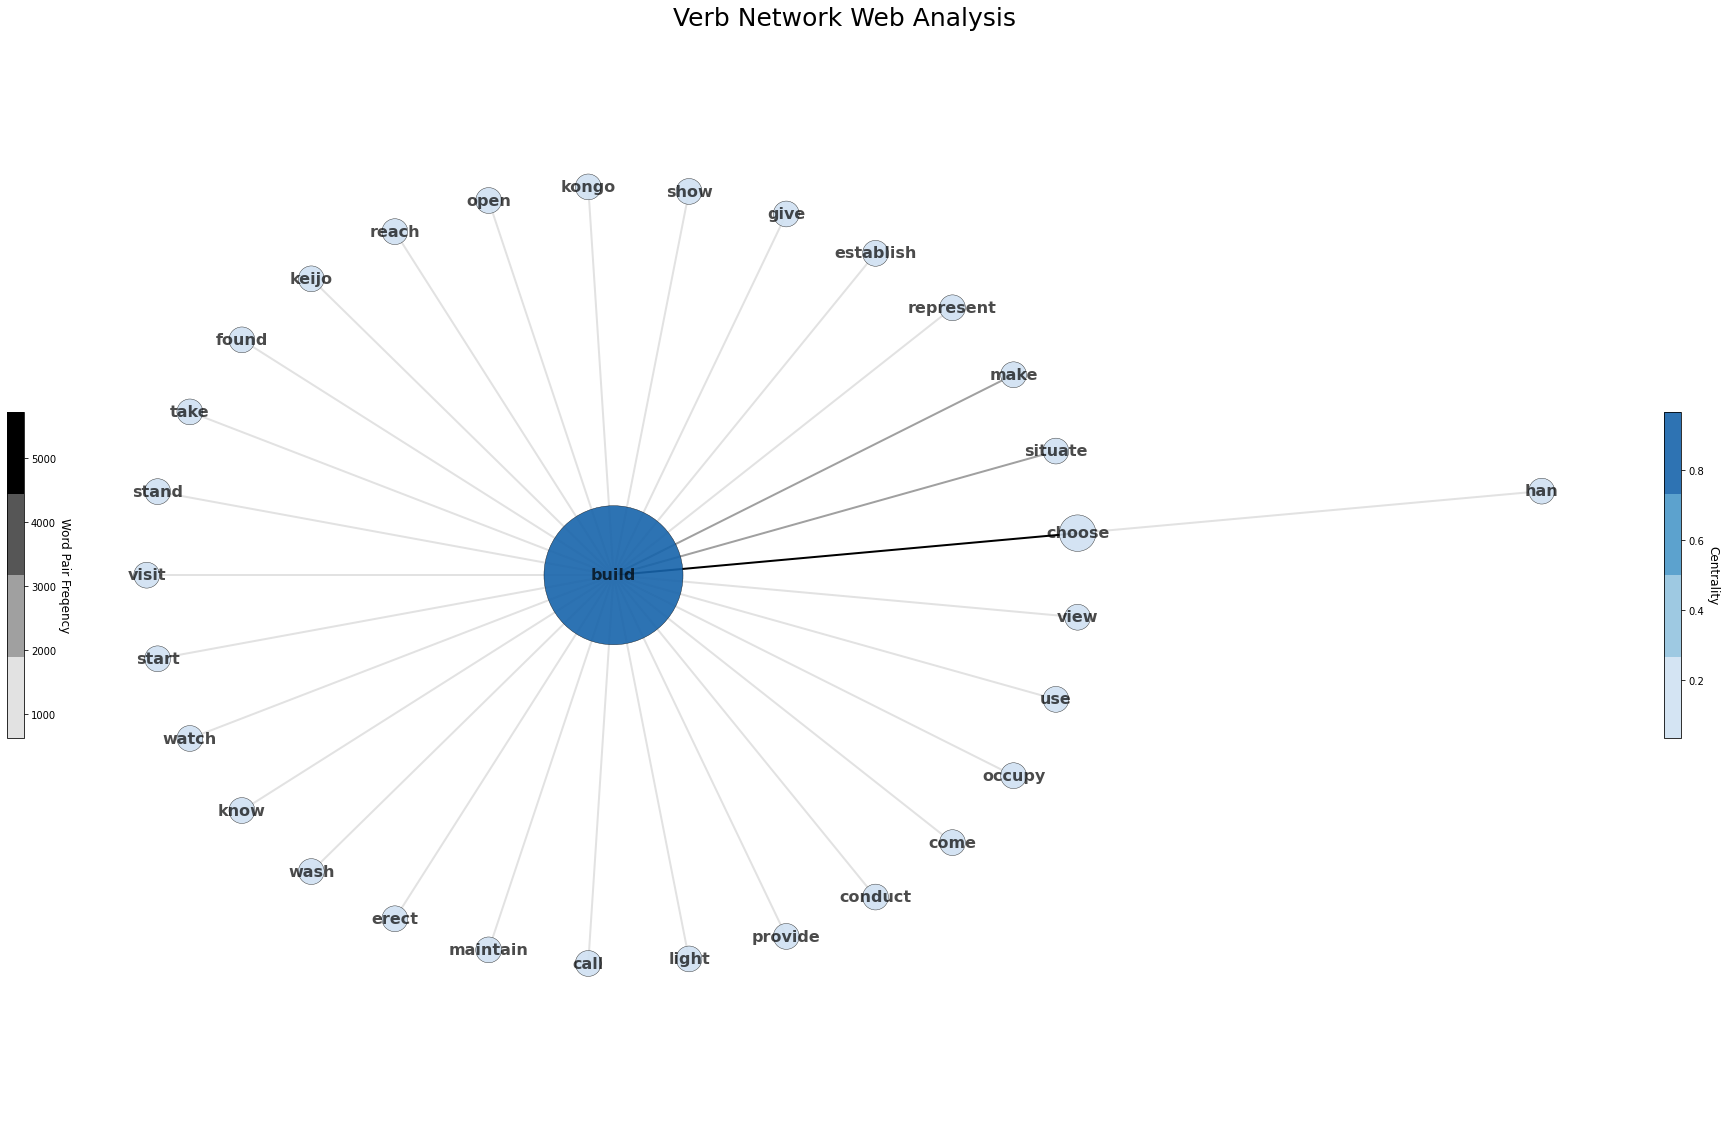

In [46]:
net = Network()

# '단어 중심성' 계산
# degree Centrality, Page Rank
net.calc_properties(edge_num=30, data=verb_freq)

# Network 시각화
net.plot(title='Verb Network Web Analysis', root=RESULT_ROOT)

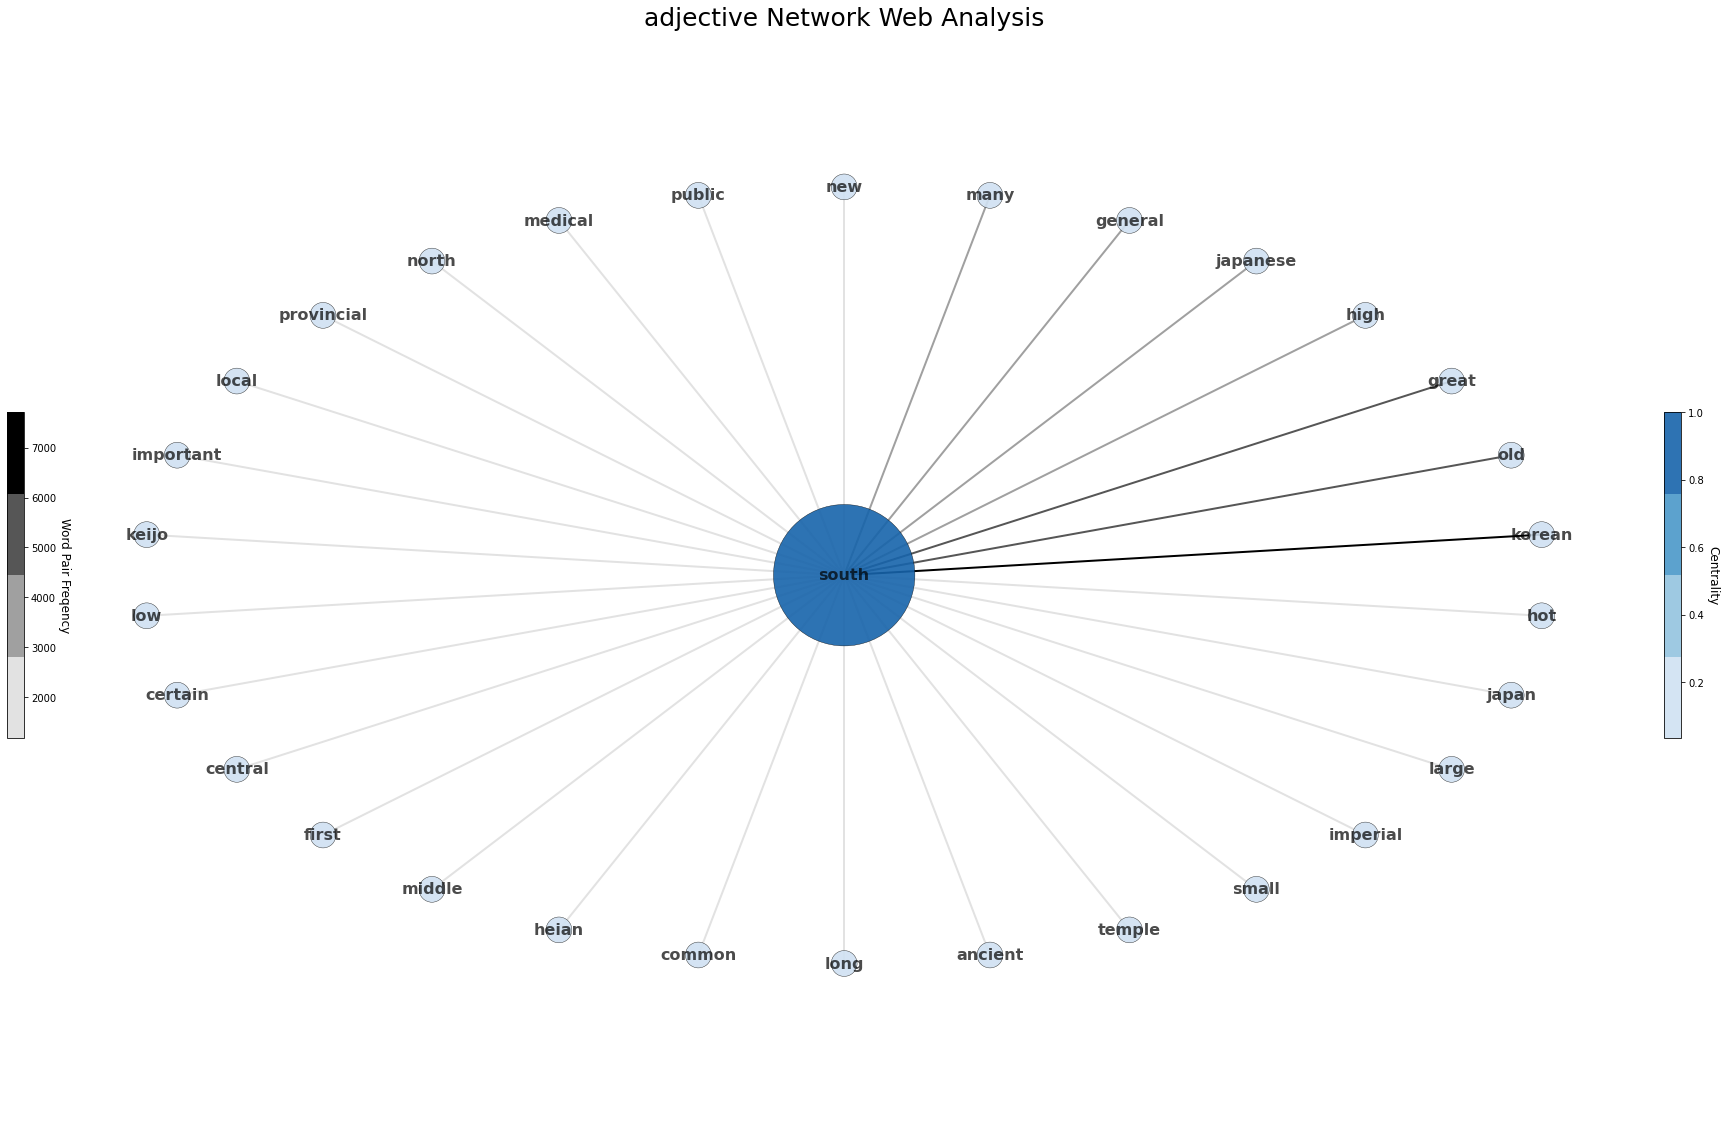

In [47]:
net = Network()

# '단어 중심성' 계산
# degree Centrality, Page Rank
net.calc_properties(edge_num=30, data=adjective_freq)

# Network 시각화
net.plot(title='adjective Network Web Analysis', root=RESULT_ROOT)

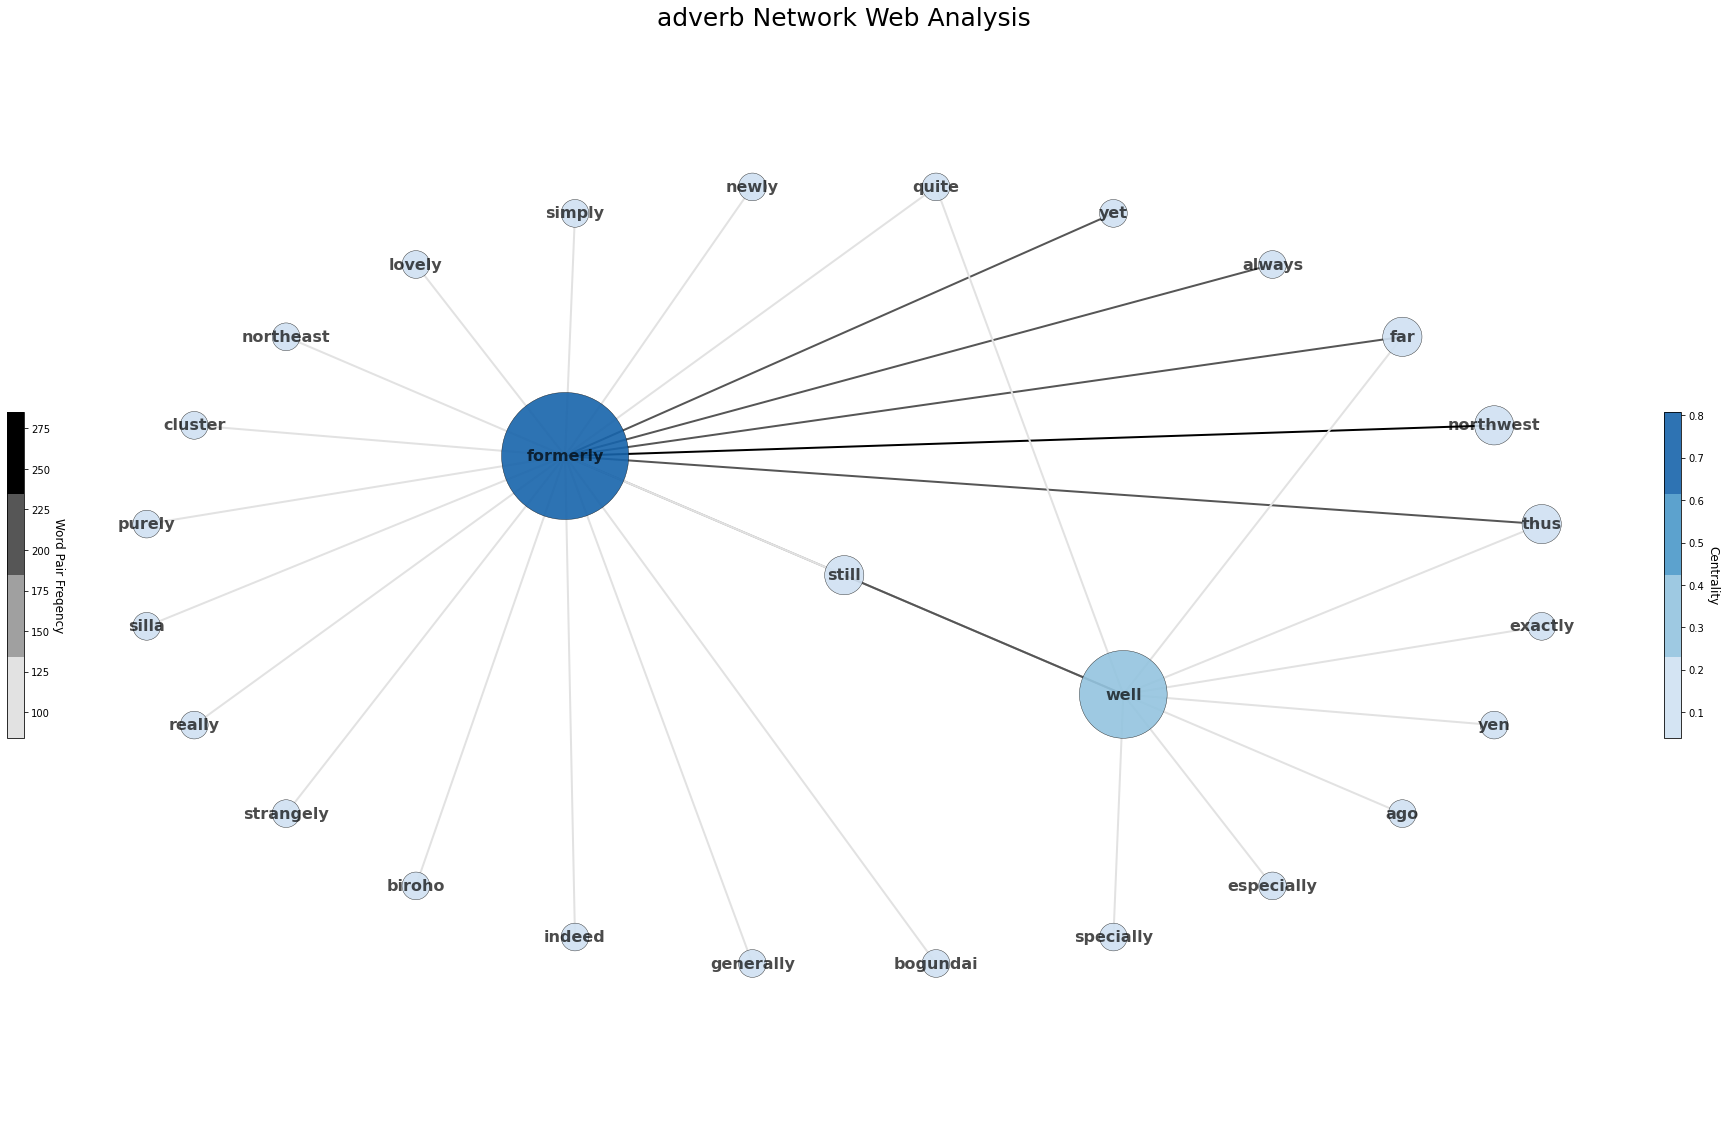

In [48]:
net = Network()

# '단어 중심성' 계산
# degree Centrality, Page Rank
net.calc_properties(edge_num=30, data=adverb_freq)

# Network 시각화
net.plot(title='adverb Network Web Analysis', root=RESULT_ROOT)